In [7]:
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler
import skimage.segmentation as seg

import numpy as np

import nglpy_cuda as ngl
import topopy
import pdir
import time
import os
import utpy.utils
import utpy.vis

# Upsampled Flow Velocity Example

In [3]:
from utpy.pipeline import analyze_external
filename = "upSampled"
n_clusters = 36
my_dir = "output/{}".format(filename)
ensemble = utpy.utils.load_ensemble(filename)

In [4]:
survival_counts = np.zeros(ensemble.shape)
weighted_survival_counts = np.zeros(ensemble.shape)
weighted_instability_counts = np.zeros(ensemble.shape)
weighted_consumption_counts = np.zeros(ensemble.shape)
for i in range(ensemble.shape[2]):
    survival_counts[:, :, i], weighted_survival_counts[:, :, i], weighted_instability_counts[:, :, i], weighted_consumption_counts[:, :, i] = utpy.utils.count_persistence(ensemble[:, :, i])
    
sc_sum = np.sum(survival_counts, axis=2)
sc_med = np.sum(survival_counts, axis=2)

wsc_sum = np.sum(weighted_survival_counts, axis=2)
wsc_med = np.median(weighted_survival_counts, axis=2)

wic_sum = np.sum(weighted_instability_counts, axis=2)
wic_med = np.median(weighted_instability_counts, axis=2)

wcc_sum = np.sum(weighted_consumption_counts, axis=2)
wcc_med = np.median(weighted_consumption_counts, axis=2)

In [ ]:
all_ps, all_counts = utpy.vis.show_persistence_charts(ensemble, my_dir, True)

In [6]:
persistence = utpy.utils.get_persistence_from_count(ensemble, n_clusters)

(0, 61)

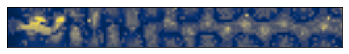

In [8]:
plt.figure()

img = plt.imshow(ensemble[:,:,0], cmap="cividis", vmin=ensemble[:,:,0].min(), vmax=ensemble[:,:,0].max())
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().set_ylim(0, ensemble[:,:,0].shape[0])

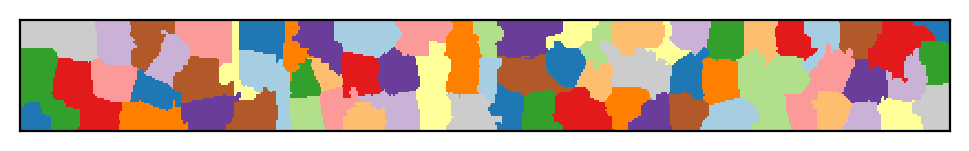

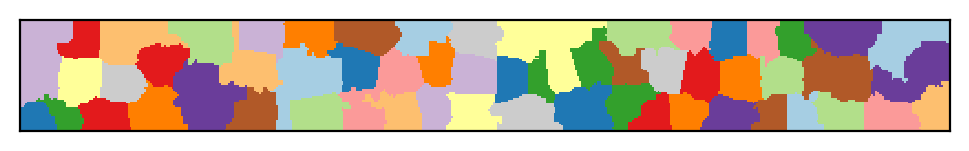

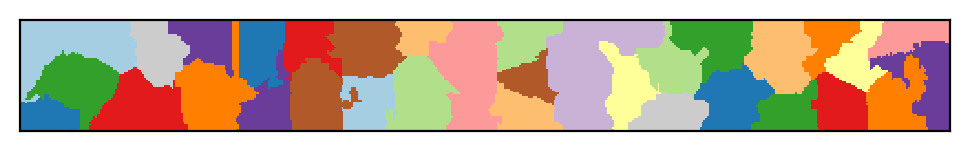

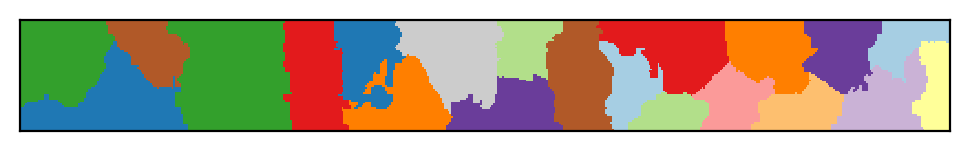

In [10]:
def segment(n_segments):
    image_slic = seg.slic(wcc_sum, n_segments=n_segments)

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    ccycle = cycle(colorList)

    uniqueCount = len(np.unique(image_slic))
    usedColors = []
    for i, c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([k for k in np.unique(image_slic)]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)

    plt.figure(dpi=200)
    plt.imshow(image_slic, cmap=cmap, interpolation="nearest", origin="lower")
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    
segment(100)
segment(75)
segment(50)
segment(25)

# Ackley Non-Parametric Case

In [11]:
import utpy.utils
import utpy.vis
import flatpy
from functools import partial
from itertools import cycle

In [12]:
foo = flatpy.nD.available_functions["ackley"]
fractional_noise_level=0.6
persistence = 0.665
n_clusters = 9
count = 50
noise_level = 0.5*persistence*fractional_noise_level
noise_model = "nonparametric"
ground_truth, ensemble = utpy.utils.generate_ensemble(foo, noise_level, count, noise_model)
ensemble = -ensemble
ground_truth = -ground_truth

graph_params = {
    "index": None, "max_neighbors": 10, "relaxed": False, "beta": 1, "p": 2.
}

In [13]:
mean_realization = np.mean(ensemble, axis=2)
median_realization = np.median(ensemble, axis=2)

In [40]:
def show_msc(grid, persistence=None, n_clusters=None, color="#000000"):
    X, Y = utpy.utils.massage_data(grid)
    h, w = grid.shape

    graph = ngl.EmptyRegionGraph(**graph_params)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization=None)
    tmc.build(X, Y)

    if persistence is None:
        for p in tmc.persistences:
            if len(tmc.get_partitions(p).keys()) <= n_clusters:
                persistence = p
                break

    partitions = tmc.get_partitions(persistence)
    keys = partitions.keys()

    keyMap = {}
    levels = []
    for i, k in enumerate(keys):
        keyMap[k] = i
        levels.append(i+0.5)

    colorList = [
        "#1f78b4",
        "#33a02c",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
        "#a6cee3",
        "#b2df8a",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#cccccc",
    ]

    ccycle = cycle(colorList)

    uniqueCount = len(keys)
    usedColors = []
    for i, c in zip(range(uniqueCount), ccycle):
        usedColors.append(c)
    cmap = colors.ListedColormap(usedColors)
    bounds = np.array([keyMap[k] for k in keys]) - 0.5
    bounds = bounds.tolist()
    bounds.append(bounds[-1]+1)

    color_mesh = np.zeros((h, w))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    for i in keyMap.values():
        lines = plt.contour(color_mesh == i, colors=color, levels=levels, linewidths=1)
    plt.gca().set_aspect("equal")
    return lines

In [47]:
def show_contour_overlay(ensemble, assignments):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(*[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[0.99999, 1], colors=my_color, alpha=0.5)
#         if colored:
#             plt.contourf(colored_images[i][:, :, 3], levels=[
#                          1e-6, 1], colors=my_color, alpha=0.5)
#         else:
#             plt.contourf(colored_images[i][:, :, 3], levels=[
#                          0.99999, 1], colors=my_color, alpha=0.5)
        plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                    1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

In [54]:
def show_combined_overlay(ensemble, assignments, gamma=2.2, contours=False):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    composite_image = 255*np.ones(colored_images[0].shape)[:, :, :-1]
    for colored_image in colored_images:
        composite_image = utpy.vis.overlay_alpha_image_precise(
            composite_image, 255*colored_image, 1.1, gamma)
    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{}{}{}".format(*[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors="#FFFFFF", alpha=1)
        if contours:
            plt.contour(colored_images[i][:, :, 3], levels=[
                        0.5, 1], colors="#999999", linewidths=[2, 1.0], linestyles=['dotted', 'solid'])

    plt.imshow(composite_image)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])

In [17]:
persistence = utpy.utils.get_persistence_from_count(ensemble, n_clusters)
maxima_map = utpy.utils.create_assignment_map(ensemble, n_clusters=n_clusters, persistence=persistence)
assignments = partial(utpy.utils.assign_labels, maxima_map=maxima_map, n_clusters=n_clusters, persistence=persistence)

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/scikit_learn-0.20.0-py3.6-linux-x86_64.egg/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
color_list = [[141, 211, 199], [255, 255, 179], [190, 186, 218],
              [251, 128, 114], [128, 177, 211], [253, 180, 98],
              [179, 222, 105], [252, 205, 229], [217, 217, 217]]
# color_list = [[228,26,28], [55,126,184], [77,175,74],
#               [152,78,163],[255,127,0],[255,255,51],
#               [166,86,40],[247,129,191],[153,153,153]]
# color_list = [[105,239,123], [149,56,144], [66,30,200],
#                 [14,80,62], [153,222,249], [24,81,155],
#                 [218,185,255], [192,222,164], [183,211,33]]
# color_list = [[251,180,174],[179,205,227],[204,235,197],
#               [222,203,228],[254,217,166],[255,255,204],
#               [229,216,189],[253,218,236],[242,242,242]]

ccycle = cycle(color_list)

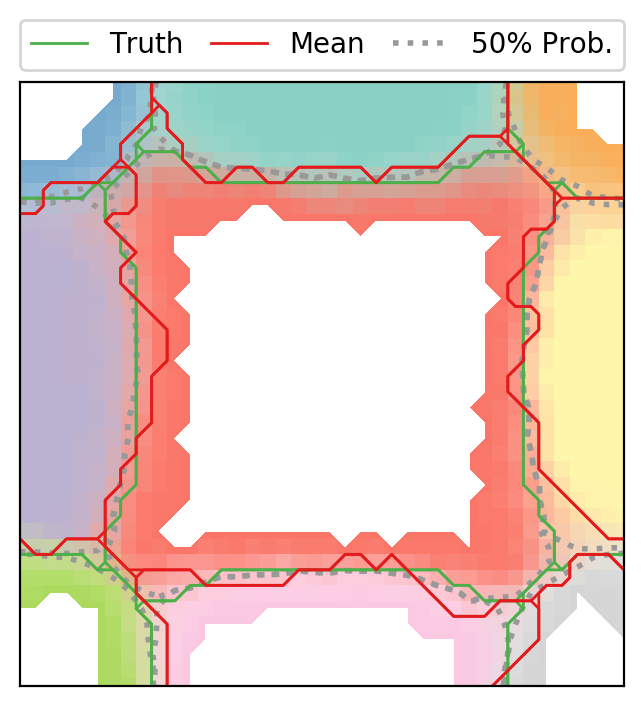

In [55]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.2, True)
show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="Truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="Mean")
plt.plot([-1,-0.5], [0,1], color="#999999", linestyle="dotted", linewidth=2, label="50% Prob.")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)


In [56]:
def show_certain_regions(ensemble, assignments, contours=False):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(
            *[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors=my_color, alpha=1)
        if contours:
            plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                        1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
        # else:
        #     plt.contour(colored_images[i][:, :, 3], levels=[0.0, 1], colors=my_color, linewidths=[
        #                 1, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

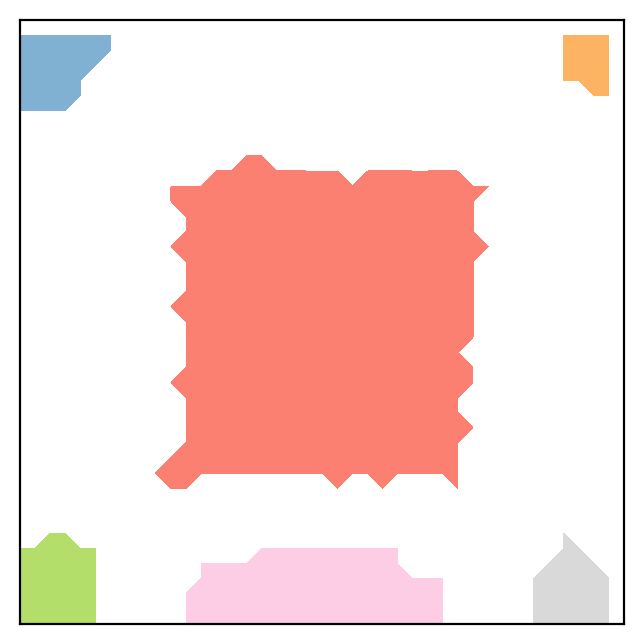

In [57]:
plt.figure(dpi=200)
show_certain_regions(ensemble, assignments)

In [ ]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.6, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

In [ ]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.8, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

In [ ]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 2.2, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)